In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('src/Electric_Production.csv')

In [3]:
df.DATE = pd.to_datetime(df.DATE)

In [4]:
df = df.set_index('DATE')

In [5]:
df

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


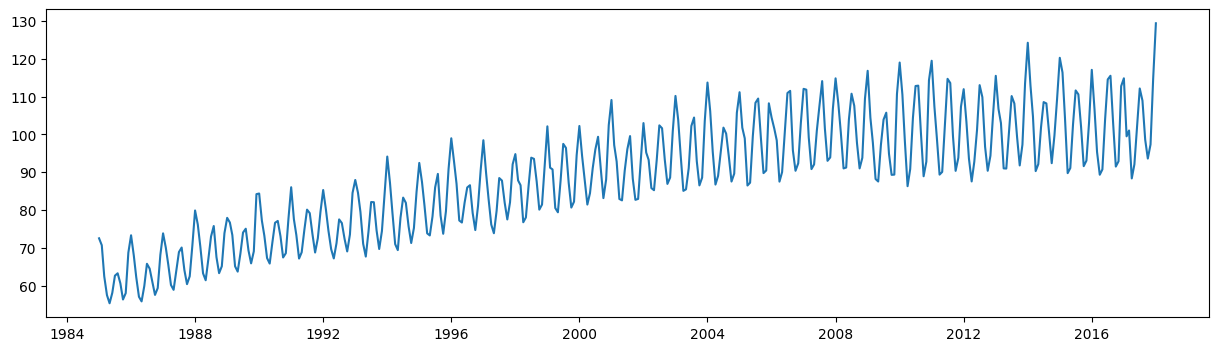

In [7]:
plt.figure(figsize=(15,4))

plt.plot(df.IPG2211A2N)

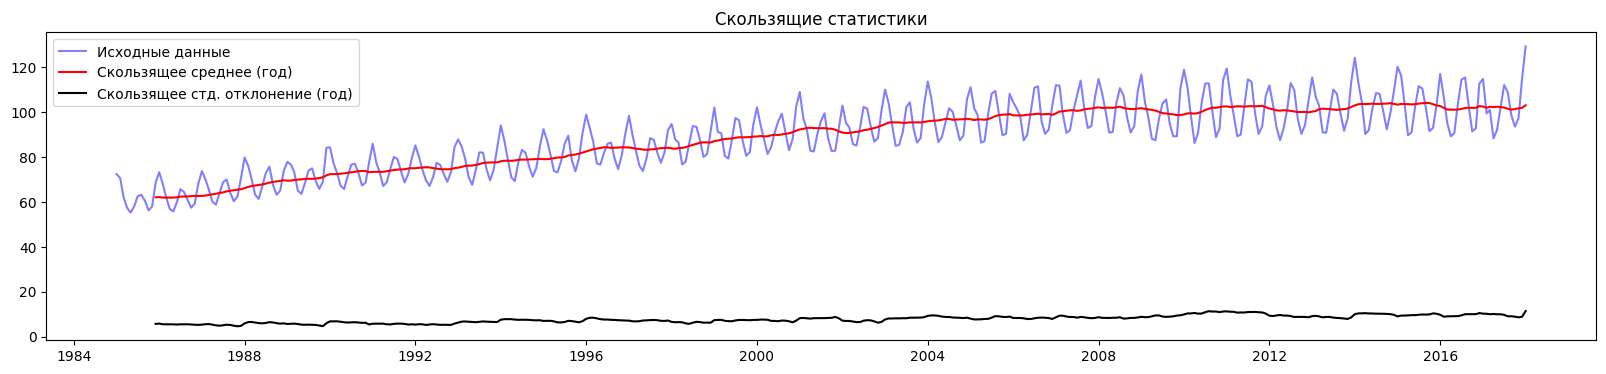

In [8]:
roll_mean = df.IPG2211A2N.rolling(window=12).mean()
roll_std = df.IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(df.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (год)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (год)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
dftest = adfuller(df.IPG2211A2N)
dftest[1], dftest[0]

(0.18621469116587053, -2.2569903500472366)

In [12]:
df['log_IPG2211A2N'] = np.log(df.IPG2211A2N + 1e-6)

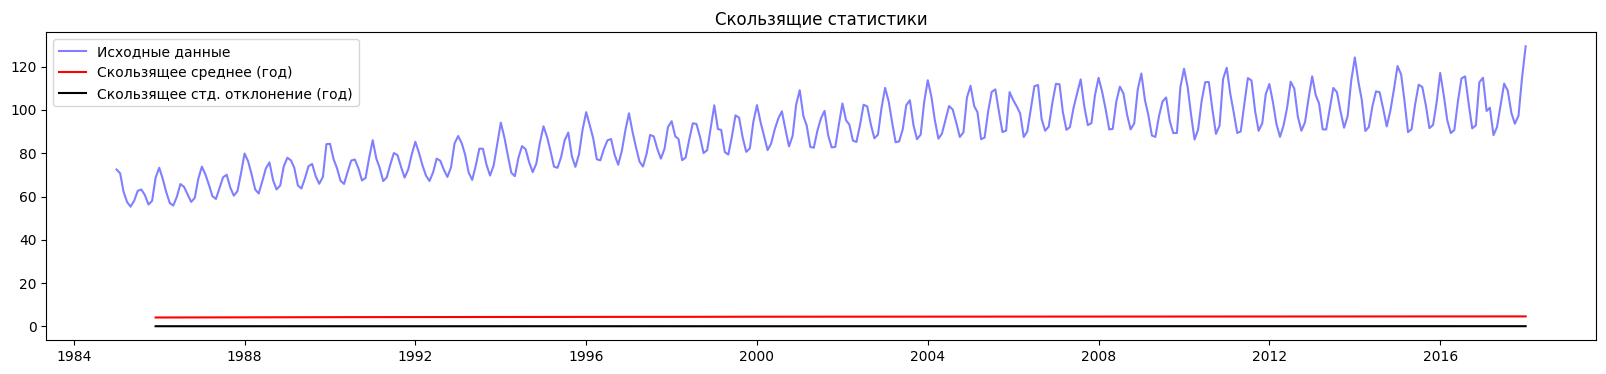

In [ ]:
roll_mean = df.log_IPG2211A2N.rolling(window=12).mean()
roll_std = df.log_IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(df.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (год)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (год)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

In [13]:
dftest_log = adfuller(df.log_IPG2211A2N)
dftest_log[1], dftest_log[0]

(0.02337340179331772, -3.145360416640731)

In [62]:
# разбиение на train & test
test_size = 84
split_date = df.index[-test_size]

train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

In [61]:
test.shape

(84, 2)

In [15]:
from sklearn.preprocessing import StandardScaler

In [64]:
train_array = train.log_IPG2211A2N.values.reshape(-1, 1)
test_array = test.log_IPG2211A2N.values.reshape(-1, 1)

In [65]:
test_array.shape

(84, 1)

In [44]:
def create_sequences(data, look_back=12):
    X, Y = [], []
    for i in range(len(data) - look_back):
        sequence = data[i:(i + look_back), 0]
        X.append(sequence)

        target = data[i + look_back, 0]
        Y.append(target)

    return np.array(X), np.array(Y)

In [66]:
scaler = StandardScaler()

train_scaler = scaler.fit_transform(train_array)
test_scaler = scaler.transform(test_array)

In [46]:
test_scaler.shape

(84, 1)

In [67]:
X_train, y_train = create_sequences(train_scaler, 12)
X_test, y_test = create_sequences(test_scaler, 12)

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM

In [68]:
N = 12
n_features = 1

model = Sequential()

model.add(GRU(
    units=50,
    return_sequences=True,
    input_shape=(N, n_features)    
))

model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

/Users/f3/docs/courses_ml/venv2/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=50,      
    batch_size=32,
    validation_split=0.1
)

In [70]:
X_test.shape

(72, 12)

In [71]:
predictions_norm = model.predict(X_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x140bcef20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


In [72]:
predictions_norm.shape

(72, 1)

In [73]:
pred_log = scaler.inverse_transform(predictions_norm)

In [74]:
pred = np.exp(pred_log).flatten()

In [75]:
test_log_restored = scaler.inverse_transform(y_test.reshape(-1, 1))

test_final_actual = np.exp(test_log_restored).flatten()

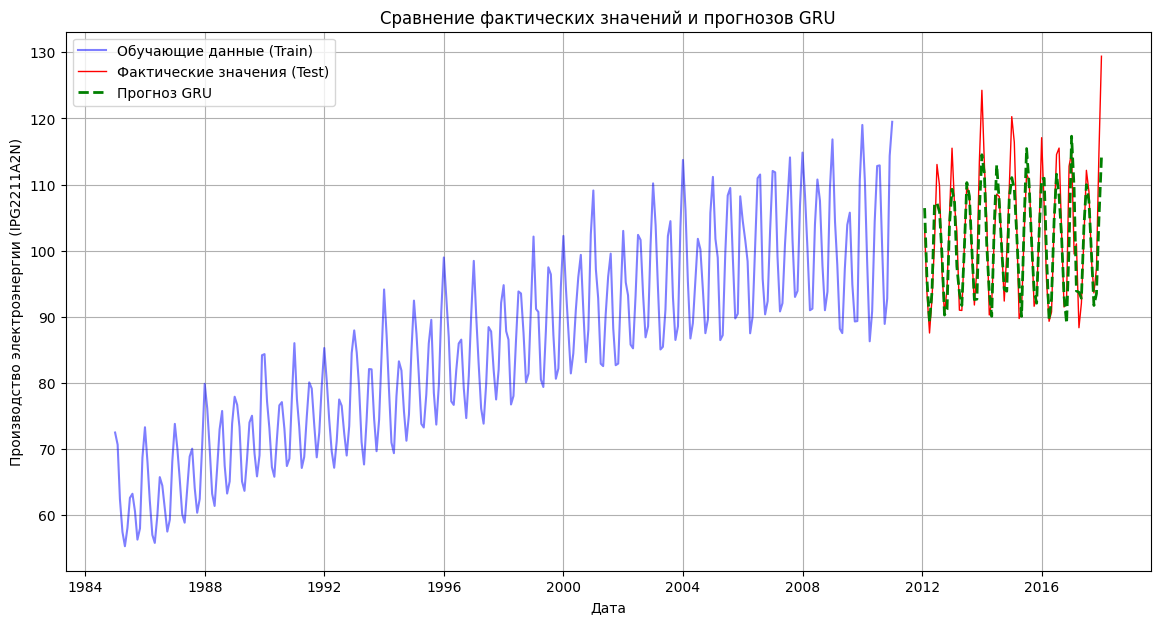

In [77]:
N = 12

start_index = test.index[N]
forecast_index = test.index[N:]

forecast_series = pd.Series(pred, index=forecast_index)
actual_series = pd.Series(test_final_actual, index=forecast_index)

plt.figure(figsize=(14, 7))

plt.plot(train.index, train['IPG2211A2N'], label='Обучающие данные (Train)', color='blue', alpha=0.5)
plt.plot(actual_series.index, actual_series, label='Фактические значения (Test)', color='red', linewidth=1)
plt.plot(forecast_series.index, forecast_series, label='Прогноз GRU', color='green', linestyle='--', linewidth=2)

plt.title('Сравнение фактических значений и прогнозов GRU')
plt.xlabel('Дата')
plt.ylabel('Производство электроэнергии (IPG2211A2N)')
plt.legend()
plt.grid(True)

_____

In [79]:
SEQ_LENGTH = 12

In [80]:
def create_sequences_2(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].values)
        y.append(data.iloc[i + seq_length].values)
    return np.array(X), np.array(y)

In [81]:
X_train, y_train = create_sequences(train_scaler, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaler, SEQ_LENGTH)

In [86]:
X_train.shape

(301, 12)

In [87]:
input_shape = (X_train.shape[1], 1)

model_lstm = Sequential()

model_lstm.add(LSTM(
    units=50, 
    input_shape=input_shape,
    return_sequences=False # Если это последний LSTM/GRU слой перед Dense
))

model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

/Users/f3/docs/courses_ml/venv2/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [97]:
history_lstm = model_lstm.fit(
    X_train, 
    y_train, 
    epochs=50,       
    batch_size=32,    
    validation_split=0.1, 
    verbose=1,
    shuffle=False 
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1500 - val_loss: 0.1393
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1310 - val_loss: 0.1379
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1224 - val_loss: 0.1234
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1218 - val_loss: 0.1196
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1216 - val_loss: 0.1138
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1114 - val_loss: 0.1162
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1123 - val_loss: 0.1064
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1065 - val_loss: 0.1074
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0969 - val_loss: 0.1011
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1014 - val_loss: 0.1054
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1167 - val_loss: 0.0996
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1186 - val_loss: 0.1029
E

In [98]:
predictions_norm_lstm = model_lstm.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [99]:
pred_log_restored_lstm = scaler.inverse_transform(predictions_norm_lstm) 

pred_final_lstm = np.exp(pred_log_restored_lstm).flatten() 

y_test_reshaped = y_test.reshape(-1, 1)

test_log_restored_lstm = scaler.inverse_transform(y_test_reshaped)

test_final_actual_lstm = np.exp(test_log_restored_lstm).flatten() 

In [100]:
N = SEQ_LENGTH 
forecast_index = test.index[N:]

forecast_series_lstm = pd.Series(pred_final_lstm, index=forecast_index)
actual_series_lstm = pd.Series(test_final_actual_lstm, index=forecast_index)

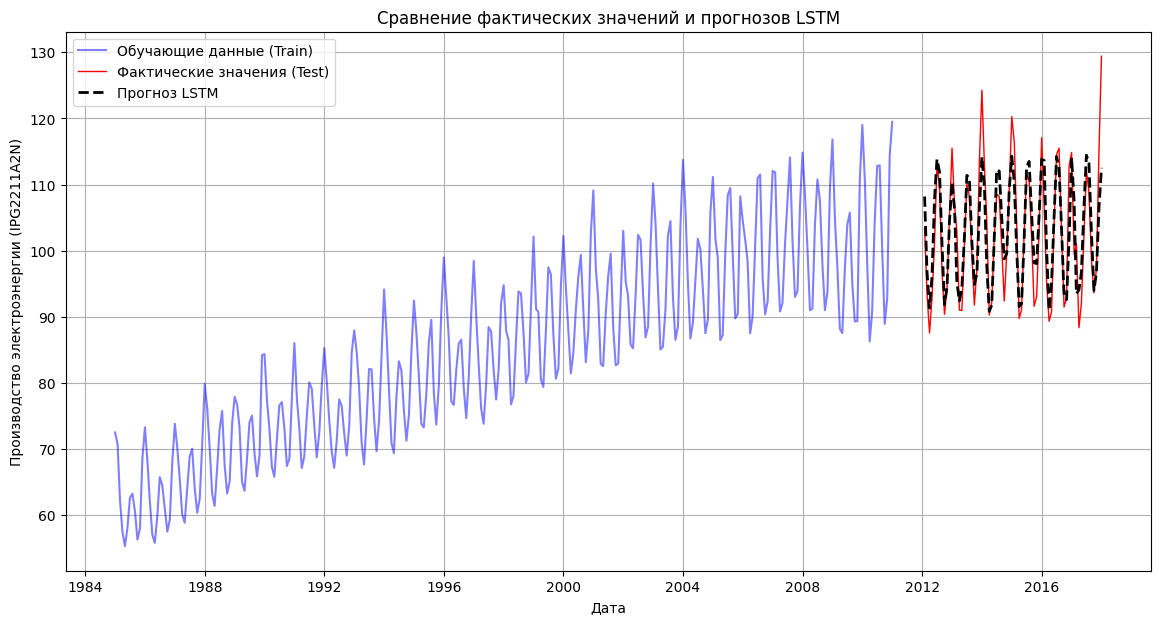

In [101]:
plt.figure(figsize=(14, 7))

plt.plot(train.index, train['IPG2211A2N'], label='Обучающие данные (Train)', color='blue', alpha=0.5)
plt.plot(actual_series_lstm.index, actual_series_lstm, label='Фактические значения (Test)', color='red', linewidth=1)
plt.plot(forecast_series_lstm.index, forecast_series_lstm, label='Прогноз LSTM', color='black', linestyle='--', linewidth=2)

plt.title('Сравнение фактических значений и прогнозов LSTM')
plt.xlabel('Дата')
plt.ylabel('Производство электроэнергии (IPG2211A2N)')
plt.legend()
plt.grid(True)